In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image
import cv2
from scipy.signal import spectrogram
from tensorflow.keras.preprocessing import image

In [3]:
# Step 1: Loading Labels
label_file_path = "/content/drive/MyDrive/Oil_GVF_prediction_CNN_models/gas_label.csv"
labels_df = pd.read_csv(label_file_path)

In [4]:
labels_df.head()

,Experiment Number,Background Flow (m3/h),GVF(%)
0,be22003_028,5,0
1,be22004_000,5,5
2,be22004_001,5,10
3,be22004_002,5,22
4,be22004_003,5,42


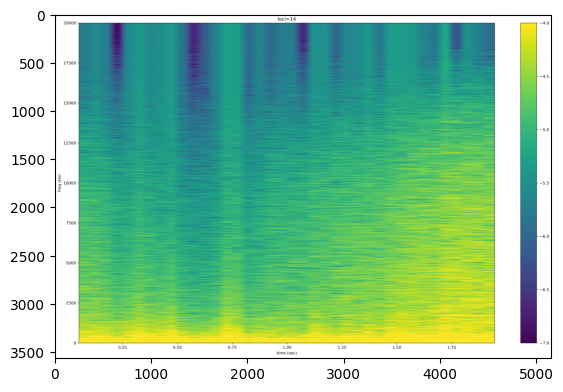

In [5]:
image_check = image.load_img("/content/drive/MyDrive/Oil_GVF_prediction_CNN_models/STFT_domain_Oil_gas_D_top_left_2_sec_img/be22003_028/15_02_2022_15_23_20_00_hdf5_cropped_1.png")
target_size = (32,32)
plt.imshow(image_check)
plt.show()

In [6]:
# Step 2: Feature Extraction (Preprocessing + Spectrogram + Statistical Features)
def extract_features(image_path):
    # Load the image
    stft_image = load_stft_image(image_path)
    # Convert the image to grayscale if it's not already
    if len(stft_image.shape) == 3 and stft_image.shape[2] == 3:
        stft_image = cv2.cvtColor(stft_image, cv2.COLOR_BGR2GRAY)
    # Flatten the image array to 1-dimensional
    stft_image_flat = stft_image.flatten()
    # Compute the spectrogram
    f, t, Sxx = spectrogram(stft_image_flat, fs=1.0, nperseg=4)  # Adjust parameters as needed
    # Plot the spectrogram
    #plt.figure(figsize=(10, 5))
    #plt.imshow(Sxx, aspect='auto', cmap='jet', origin='lower')
    #plt.colorbar(label='Intensity')
    #plt.xlabel('Time')
    #plt.ylabel('Frequency')
    #plt.title('Spectrogram')
    #plt.show()
    # Extract statistical features from the frequency spectrum
    features = np.array([np.mean(Sxx), np.std(Sxx), np.median(Sxx), np.max(Sxx), np.min(Sxx)])
    return features

# Function to load STFT images
def load_stft_image(image_path):
    img = Image.open(image_path)
    # Convert the image to numpy array
    img_array = np.array(img)
    return img_array

In [7]:
# Extract features from images
X = []
y = []
for index, row in labels_df.iterrows():
    experiment_name = row['Experiment Number']
    bg_flow = row['Background Flow (m3/h)']
    gvf = row['GVF(%)']
    folder_path = os.path.join("/content/drive/MyDrive/Oil_GVF_prediction_CNN_models/STFT_domain_Oil_gas_D_top_left_2_sec_img", experiment_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        features = extract_features(img_path)
        X.append(features)
        y.append([bg_flow, gvf])
X = np.array(X)
y = np.array(y)

In [8]:
# Reshape X to 2D
num_samples = X.shape[0]
X_flat = X.reshape(num_samples, -1)

# Create DataFrame
columns = [f'pixel_{i}' for i in range(X_flat.shape[1])]
df_features = pd.DataFrame(X_flat, columns=columns)

# Add Background Flow and GVF columns to the DataFrame
df_features['Background Flow'] = y[:, 0]
df_features['GVF'] = y[:, 1]

In [9]:
df_features

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,Background Flow,GVF
0,7571.029297,8108.946289,4351.020996,46059.375,0.0,5,0
1,5720.605469,6023.170410,4231.708496,46059.375,0.0,5,0
2,8692.002930,8893.175781,4551.041504,46059.375,0.0,5,0
3,9275.057617,9176.164062,5046.041504,46059.375,0.0,5,0
4,8364.834961,8709.464844,4408.666504,46059.375,0.0,5,0
...,...,...,...,...,...,...,...
433,10434.769531,9634.250977,12741.333008,46059.375,0.0,30,63
434,10101.241211,9595.401367,8770.833008,46059.375,0.0,30,63
435,9582.416016,9363.775391,5928.041504,46059.375,0.0,30,63
436,8918.757812,9026.601562,4641.333496,46059.375,0.0,30,63


In [10]:
# Check if all features are same or different
feature_summary = df_features.describe()

# Display summary statistics
print(feature_summary)

# Check if all features are identical or not
are_features_identical = (feature_summary.loc['min'] == feature_summary.loc['max']).all()

if are_features_identical:
    print("All features are identical across samples.")
else:
    print("Features vary among samples.")


            pixel_0      pixel_1       pixel_2       pixel_3  pixel_4  \
count    438.000000   438.000000    438.000000    438.000000    438.0   
mean    8967.101562  8894.883789   6096.627441  46059.378906      0.0   
std     1244.715332   916.836914   2078.679932      0.000000      0.0   
min     5386.218262  5601.436035   3780.750000  46059.375000      0.0   
25%     8417.838623  8744.019287   4429.708496  46059.375000      0.0   
50%     9410.805664  9251.622070   5359.687500  46059.375000      0.0   
75%     9819.256104  9465.607910   6960.000000  46059.375000      0.0   
max    10545.468750  9696.427734  15194.041992  46059.375000      0.0   

       Background Flow         GVF  
count       438.000000  438.000000  
mean         17.271689   25.342466  
std          12.512206   22.249296  
min           5.000000    0.000000  
25%           5.000000    5.000000  
50%           5.000000   22.000000  
75%          30.000000   42.000000  
max          30.000000   65.000000  
Features 

In [11]:
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [12]:
# Step 4: Model Training
# Define the custom model
custom_model = Sequential()
custom_model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
custom_model.add(Dropout(0.2))
custom_model.add(Dense(128, activation='relu'))
custom_model.add(Dropout(0.2))
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.2))
custom_model.add(Dense(1024, activation='relu'))
custom_model.add(Dropout(0.2))
custom_model.add(Dense(32, activation='relu'))
custom_model.add(Dense(2))  # Output layer with 2 neurons for Background Flow and GVF

# Compile the model
custom_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1536      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              5

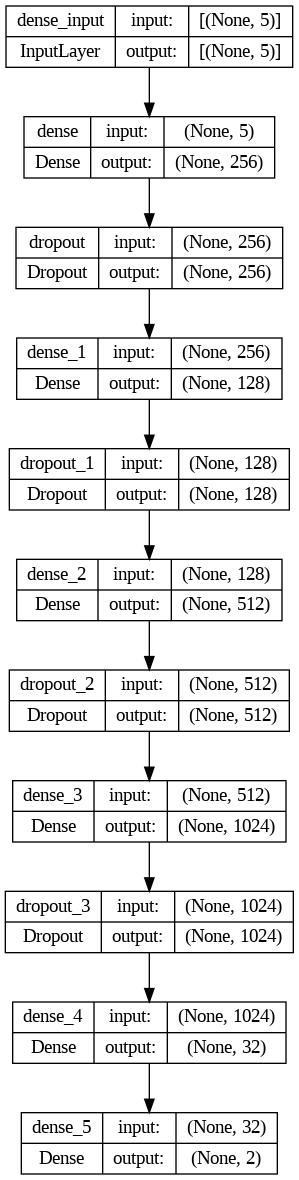

In [13]:
from tensorflow.keras.utils import plot_model

# Print the summary of the model
custom_model.summary()

# Save the model architecture as an image
plot_model(custom_model, to_file='custom_model.png', show_shapes=True)


In [14]:
# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = custom_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
4/4 [==============================] - 2s 90ms/step - loss: 789.1591 - mae: 21.2344 - val_loss: 765.2612 - val_mae: 20.8799
Epoch 2/20
4/4 [==============================] - 0s 27ms/step - loss: 708.6029 - mae: 19.4469 - val_loss: 606.7526 - val_mae: 17.6263
Epoch 3/20
4/4 [==============================] - 0s 26ms/step - loss: 518.1259 - mae: 16.2219 - val_loss: 386.5108 - val_mae: 15.0065
Epoch 4/20
4/4 [==============================] - 0s 31ms/step - loss: 412.3022 - mae: 16.0383 - val_loss: 310.3842 - val_mae: 14.2547
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 297.5053 - mae: 13.8179 - val_loss: 273.8708 - val_mae: 13.2690
Epoch 6/20
4/4 [==============================] - 0s 26ms/step - loss: 269.9922 - mae: 12.9855 - val_loss: 256.4381 - val_mae: 13.7834
Epoch 7/20
4/4 [==============================] - 0s 25ms/step - loss: 254.5055 - mae: 13.5981 - val_loss: 265.3026 - val_mae: 14.5821
Epoch 8/20
4/4 [==============================] - 0s 30

In [15]:
# Step 5: Model Evaluation
# Evaluate the model on the test set
evaluation = custom_model.evaluate(X_test, y_test)
print("Evaluation Loss:", evaluation[0])
print("Evaluation MAE:", evaluation[1])

5/5 [==============================] - 0s 4ms/step - loss: 263.3574 - mae: 13.2174
Evaluation Loss: 263.35736083984375
Evaluation MAE: 13.217405319213867


In [16]:
print(history.history.keys())
history_model = pd.DataFrame({"loss": history.history['loss'], 'val_loss': history.history['val_loss'], 'mae': history.history['mae'], 'val_mae': history.history['val_mae']})

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [17]:
history_model

,loss,val_loss,mae,val_mae
0,789.159058,765.261169,21.234379,20.879887
1,708.602905,606.752625,19.446903,17.626280
2,518.125854,386.510834,16.221931,15.006452
3,412.302246,310.384247,16.038298,14.254743
4,297.505341,273.870789,13.817934,13.268984
5,269.992157,256.438141,12.985531,13.783431
6,254.505478,265.302551,13.598074,14.582079
7,248.637070,261.349152,13.691096,14.251994
8,251.071915,261.744293,13.557993,13.800347
9,243.318832,257.089447,13.129803,13.602754


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Step 5: Model Evaluation

# Predictions for test set
predictions = custom_model.predict(X_test)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)



5/5 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 13.217405833981253
Mean Squared Error (MSE): 263.3573750466928


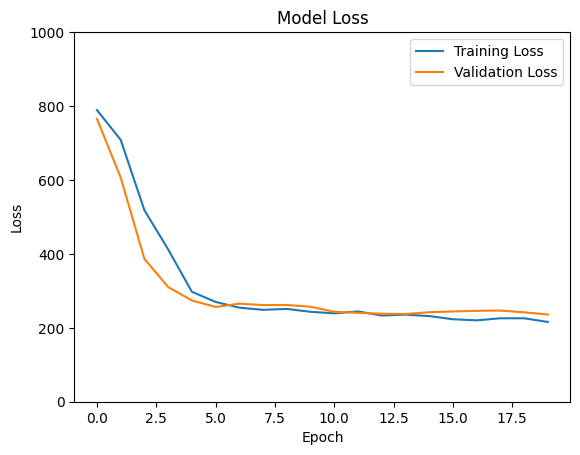

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1000)  # Set y-axis range
plt.show()

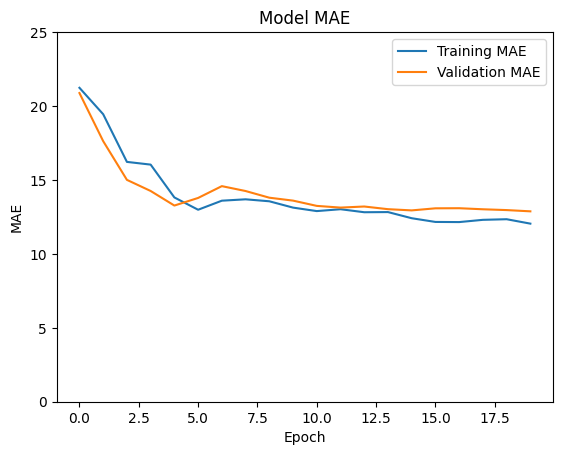

In [20]:
# Plot training & validation MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.ylim(0, 25)  # Set y-axis range
plt.show()


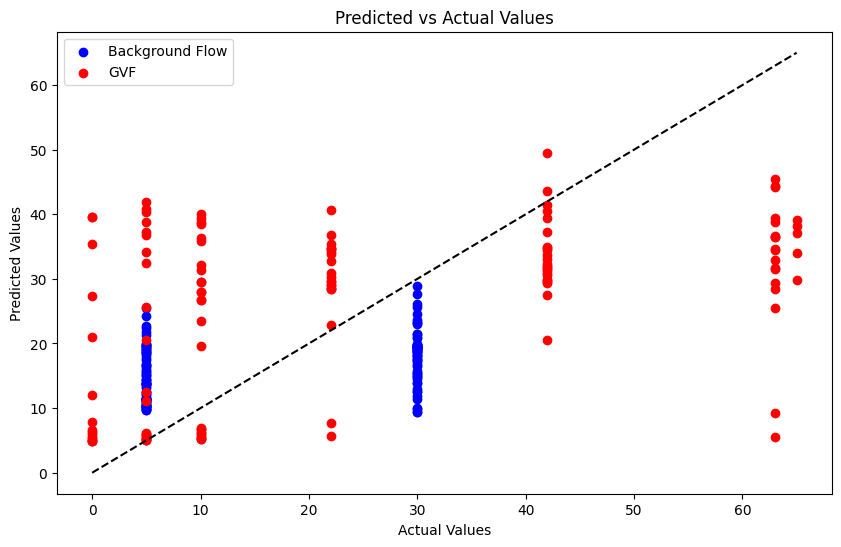

In [21]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:, 0], predictions[:, 0], color='blue', label='Background Flow')
plt.scatter(y_test[:, 1], predictions[:, 1], color='red', label='GVF')
plt.plot([min(y_test.min(), predictions.min()), max(y_test.max(), predictions.max())], [min(y_test.min(), predictions.min()), max(y_test.max(), predictions.max())], color='black', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

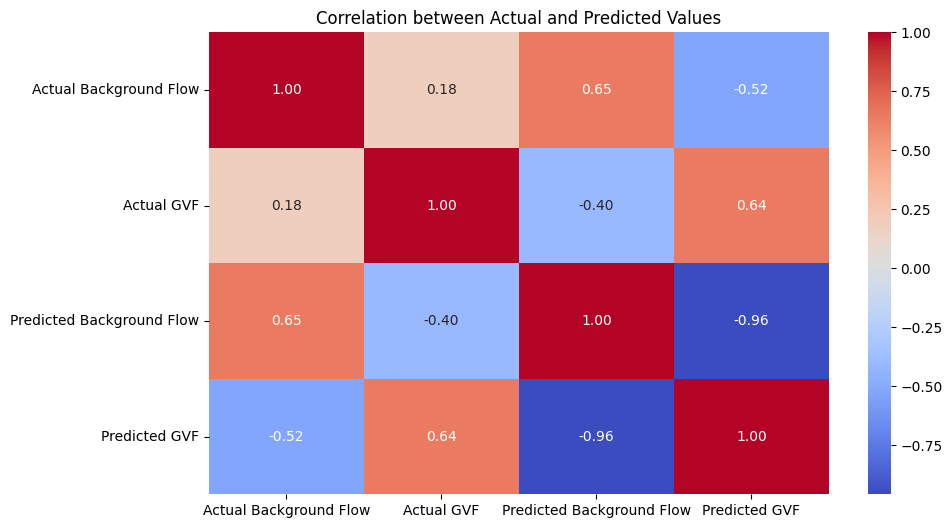

In [22]:
import seaborn as sns
# Heatmap of correlation between actual and predicted values
plt.figure(figsize=(10, 6))

# Add a small value to the diagonal of the covariance matrix
epsilon = 1e-9
cov_matrix = np.cov(np.concatenate((y_test, predictions), axis=1), rowvar=False) + epsilon * np.eye(4)

# Compute the correlation matrix
corr_matrix = np.corrcoef(cov_matrix)

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=['Actual Background Flow', 'Actual GVF', 'Predicted Background Flow', 'Predicted GVF'],
            yticklabels=['Actual Background Flow', 'Actual GVF', 'Predicted Background Flow', 'Predicted GVF'])
plt.title('Correlation between Actual and Predicted Values')
plt.show()


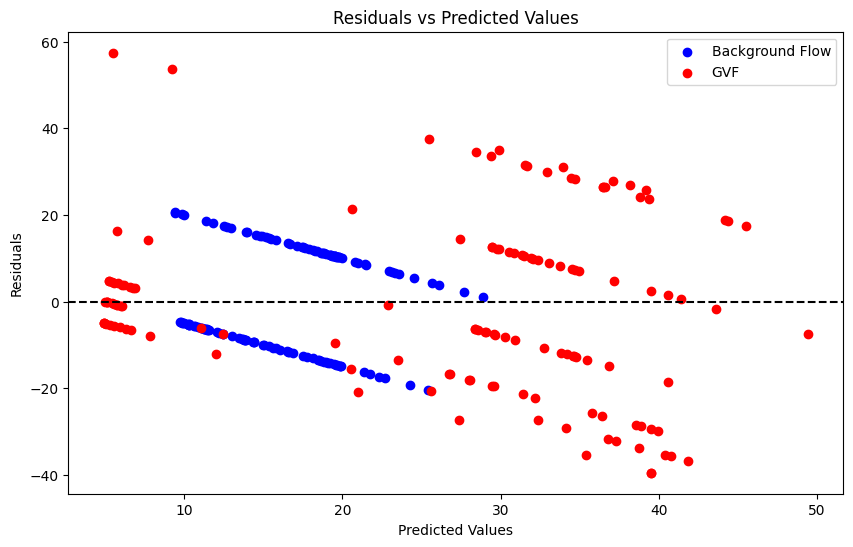

In [23]:
# Scatter plot of residuals vs predicted values
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions[:, 0], residuals[:, 0], color='blue', label='Background Flow')
plt.scatter(predictions[:, 1], residuals[:, 1], color='red', label='GVF')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [1]:
import math
def predict_single_image(image_path, model, scaler):
    # Extract features from the image
    features = extract_features(image_path)
    # Scale the features using the scaler used during training
    scaled_features = scaler.transform(features.reshape(1, -1))
    # Predict background flow and GVF
    prediction = model.predict(scaled_features)
    # Apply ReLU to ensure non-negativity
    prediction = np.maximum(prediction, 0)
    # Separate the predictions for background flow and GVF
    bg_flow_prediction = prediction[0][0]
    gvf_prediction = prediction[0][1]
    return bg_flow_prediction, gvf_prediction

# Example usage:
image_path = "/content/drive/MyDrive/Oil_GVF_prediction_CNN_models/STFT_domain_Oil_gas_D_top_left_2_sec_img/be22004_016/16_02_2022_12_37_11_00_hdf5_cropped_3.png"  # Provide the path to your image
bg_flow_pred, gvf_pred = predict_single_image(image_path, custom_model, scaler)
print("Predicted Background Flow:", math.ceil(bg_flow_pred))
print("Predicted GVF:", math.ceil(gvf_pred))


NameError: name 'custom_model' is not defined